# WESAD Stress Detection Model

Here's the steps of training a stress detection model using the WESAD dataset:
1. Load & Explore
2. Extract
3. Train
4. Evaluate

In [5]:
import sys
sys.path.append('../src')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Import WESAD helper functions
from wesad.load_wesad import load_subject_data, extract_labels, extract_chest_signals
from wesad.features_eda import extract_eda_features
from wesad.features_hrv import extract_hrv_features


## 1. Load & Explore WESAD Data

In [6]:
def load_subject(subject_dir):
    """
    Load one WESAD subject folder (e.g., .../WESAD/S2/) and return a dict:
      signals["EDA"], ["BVP"], ["ACC"], ["TEMP"], ["HR"] -> {"time": np.ndarray, "data": np.ndarray, "fs": float, "start": float}
      signals["IBI"] -> pd.DataFrame with columns ["t_rel", "ibi", "time"]
      signals["tags"] -> pd.DataFrame with column ["time"]
      signals["_paths"] -> {"subject_dir": Path, "e4_dir": Path}
    """
    subject_dir = Path(subject_dir).expanduser().resolve()
    if not subject_dir.exists():
        raise FileNotFoundError(f"Subject directory not found: {subject_dir}")

    # Find *_E4_data (case-insensitive)
    e4_candidates = [p for p in subject_dir.iterdir()
                     if p.is_dir() and p.name.lower().endswith("_e4_data")]
    if not e4_candidates:
        contents = [p.name for p in subject_dir.iterdir()]
        raise FileNotFoundError(
            f"No '*_E4_data' folder found inside: {subject_dir}\n"
            f"Contents: {contents}"
        )
    if len(e4_candidates) > 1:
        e4_candidates.sort()
    e4_dir = e4_candidates[0]

    def _load_standard_signal(csv_name, expect_cols=None):
        p = e4_dir / csv_name
        if not p.exists():
            raise FileNotFoundError(f"Missing file: {p}")

        raw = pd.read_csv(p, header=None)
        if raw.shape[0] < 3:
            raise ValueError(f"File too short: {p} (rows={raw.shape[0]})")

        start = float(raw.iloc[0, 0])
        fs = float(raw.iloc[1, 0])
        data = raw.iloc[2:].to_numpy(dtype=float)

        if expect_cols is not None and data.shape[1] != expect_cols:
            raise ValueError(f"{p.name}: expected {expect_cols} columns, got {data.shape[1]}")

        t = start + np.arange(data.shape[0], dtype=float) / fs
        return {"time": t, "data": data, "fs": fs, "start": start}

    signals = {
        "_paths": {"subject_dir": subject_dir, "e4_dir": e4_dir}
    }

    # Standard sampled signals
    signals["EDA"]  = _load_standard_signal("EDA.csv",  expect_cols=1)
    signals["BVP"]  = _load_standard_signal("BVP.csv",  expect_cols=1)
    signals["TEMP"] = _load_standard_signal("TEMP.csv", expect_cols=1)
    signals["HR"]   = _load_standard_signal("HR.csv",   expect_cols=1)
    signals["ACC"]  = _load_standard_signal("ACC.csv",  expect_cols=3)

    # IBI: first row start unix time; remaining rows are [t_rel, ibi]
    ibi_path = e4_dir / "IBI.csv"
    if not ibi_path.exists():
        raise FileNotFoundError(f"Missing file: {ibi_path}")

    ibi_raw = pd.read_csv(ibi_path, header=None)
    if ibi_raw.shape[0] < 2 or ibi_raw.shape[1] < 2:
        raise ValueError(f"Unexpected IBI.csv shape: {ibi_raw.shape} at {ibi_path}")

    ibi_start = float(ibi_raw.iloc[0, 0])
    ibi = ibi_raw.iloc[1:, :2].copy()
    ibi.columns = ["t_rel", "ibi"]
    ibi["t_rel"] = pd.to_numeric(ibi["t_rel"], errors="coerce")
    ibi["ibi"] = pd.to_numeric(ibi["ibi"], errors="coerce")
    ibi = ibi.dropna().reset_index(drop=True)
    ibi["time"] = ibi_start + ibi["t_rel"].to_numpy(dtype=float)
    signals["IBI"] = ibi

    # tags: each row is an absolute unix timestamp
    tags_path = e4_dir / "tags.csv"
    if not tags_path.exists():
        raise FileNotFoundError(f"Missing file: {tags_path}")

    tags = pd.read_csv(tags_path, header=None, names=["time"])
    tags["time"] = pd.to_numeric(tags["time"], errors="coerce")
    tags = tags.dropna().reset_index(drop=True)
    signals["tags"] = tags

    return signals

WESAD_ROOT = Path("/Users/maggiebowen/Documents/GitHub/doomstopping/data/raw")

# test calls
signals = load_subject(WESAD_ROOT / "S2")
print(signals.keys())
print("EDA data shape:", signals["EDA"]["data"].shape)
print("IBI head:\n", signals["IBI"].head())

dict_keys(['_paths', 'EDA', 'BVP', 'TEMP', 'HR', 'ACC', 'IBI', 'tags'])
EDA data shape: (31494, 1)
IBI head:
        t_rel       ibi          time
0  14.313155  0.765660  1.495437e+09
1  15.203821  0.890666  1.495437e+09
2  15.985107  0.781286  1.495437e+09
3  16.797644  0.812537  1.495437e+09
4  17.578930  0.781286  1.495437e+09


## Label exploration and mapping
Quick helpers to inspect WESAD label segments and map them to tasks without touching existing cells.


## 2. Load All Participants with Label Mapping

Load data from all WESAD subjects (S2-S17) using the helper functions in src/wesad/load_wesad.py.
Each subject contains:
- **Chest sensors**: ECG, EDA, Resp, EMG, Temp, ACC (700Hz)
- **Labels**: Activity labels aligned to chest sampling rate
- **E4 wristband**: EDA, BVP, HR, TEMP, ACC, IBI (separate modality)

**WESAD label mapping (from official schedule):**
- 1 = Baseline
- 2 = TSST stress
- 3 = Amusement
- 4 = Meditation
- 6 = sRead (self-report/reading)
- 7 = fRead (final reading)
- 0 = transition / not-worn / between blocks

Use the quest CSV in each subject folder (e.g., `data/raw/S2/S2_quest.csv`) to line up minute-level START/END times with the run-length segments above. For binary stress modeling, collapse to stress=2 vs non-stress={1,3,4,6,7} and drop/ignore 0.

In [7]:
# Define WESAD label mapping
LABEL_MAPPING = {
    0: 'transition/not-worn',
    1: 'Baseline',
    2: 'TSST stress',
    3: 'Amusement',
    4: 'Meditation',
    6: 'sRead',
    7: 'fRead'
}

# Data structure to store all loaded subjects
all_subjects_data = {}

print('Label mapping:', LABEL_MAPPING)

Label mapping: {0: 'transition/not-worn', 1: 'Baseline', 2: 'TSST stress', 3: 'Amusement', 4: 'Meditation', 6: 'sRead', 7: 'fRead'}


In [8]:
# Iterate over all WESAD subjects (S2-S17, excluding S12 which doesn't exist)
from pathlib import Path

WESAD_ROOT = Path('/Users/maggiebowen/Documents/GitHub/doomstopping/data/raw')
subject_ids = [f'S{i}' for i in range(2, 18) if i != 12]  # S2-S17 excluding S12

print(f'Loading {len(subject_ids)} subjects...\n')

for subject_id in subject_ids:
    try:
        # Load pickle data (chest sensors + labels)
        subject_data = load_subject_data(subject_id, data_dir=WESAD_ROOT)
        
        # Extract labels
        labels = extract_labels(subject_data)
        
        # Extract chest signals
        chest_signals = extract_chest_signals(subject_data)
        
        # Store in our data structure
        all_subjects_data[subject_id] = {
            'labels': labels,
            'chest_signals': chest_signals,
            'raw_data': subject_data  # Keep reference to full data if needed
        }
        
        # Print progress
        unique_labels = np.unique(labels)
        print(f'✓ {subject_id}: {len(labels):,} samples, labels: {unique_labels.tolist()}')
        
    except FileNotFoundError as e:
        print(f'✗ {subject_id}: File not found - {e}')
    except Exception as e:
        print(f'✗ {subject_id}: Error - {e}')

print(f'\nSuccessfully loaded {len(all_subjects_data)}/{len(subject_ids)} subjects')

Loading 15 subjects...

✓ S2: 4,255,300 samples, labels: [0, 1, 2, 3, 4, 6, 7]
✓ S3: 4,545,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S4: 4,496,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S5: 4,380,600 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S6: 4,949,700 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S7: 3,666,600 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S8: 3,826,200 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S9: 3,656,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S10: 3,847,200 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S11: 3,663,100 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S13: 3,875,900 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S14: 3,883,600 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S15: 3,676,400 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S16: 3,941,700 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]
✓ S17: 4,144,000 samples, labels: [0, 1, 2, 3, 4, 5, 6, 7]

Successfully loaded 15/15 subjects


In [9]:
# Summary statistics across all loaded subjects
print('='*60)
print('WESAD DATASET SUMMARY')
print('='*60)

# Overall label distribution
all_labels = []
for subject_id, data in all_subjects_data.items():
    all_labels.extend(data['labels'].tolist())

all_labels = np.array(all_labels)
label_vals, label_counts = np.unique(all_labels, return_counts=True)

print(f'\nTotal samples across all subjects: {len(all_labels):,}')
print(f'Sampling rate: 700 Hz (chest sensors)')
print(f'Total duration: {len(all_labels)/700/60:.1f} minutes\n')

print('Label Distribution:')
print('-'*60)
for val, count in zip(label_vals, label_counts):
    label_name = LABEL_MAPPING.get(val, 'Unknown')
    percentage = 100 * count / len(all_labels)
    duration_min = count / 700 / 60
    print(f'{val}: {label_name:20s} | {count:8,} samples ({percentage:5.1f}%) | {duration_min:6.1f} min')

print('\nPer-Subject Sample Counts:')
print('-'*60)
for subject_id in sorted(all_subjects_data.keys()):
    n_samples = len(all_subjects_data[subject_id]['labels'])
    duration_min = n_samples / 700 / 60
    print(f'{subject_id}: {n_samples:7,} samples ({duration_min:5.1f} min)')

print('\nAvailable chest signals per subject:')
print('-'*60)
first_subject = list(all_subjects_data.keys())[0]
for signal_name, signal_data in all_subjects_data[first_subject]['chest_signals'].items():
    print(f'{signal_name}: shape {signal_data.shape}')

WESAD DATASET SUMMARY

Total samples across all subjects: 60,807,600
Sampling rate: 700 Hz (chest sensors)
Total duration: 1447.8 minutes

Label Distribution:
------------------------------------------------------------
0: transition/not-worn  | 27,654,897 samples ( 45.5%) |  658.4 min
1: Baseline             | 12,327,702 samples ( 20.3%) |  293.5 min
2: TSST stress          | 6,976,201 samples ( 11.5%) |  166.1 min
3: Amusement            | 3,902,501 samples (  6.4%) |   92.9 min
4: Meditation           | 8,264,199 samples ( 13.6%) |  196.8 min
5: Unknown              |  552,300 samples (  0.9%) |   13.2 min
6: sRead                |  552,998 samples (  0.9%) |   13.2 min
7: fRead                |  576,802 samples (  0.9%) |   13.7 min

Per-Subject Sample Counts:
------------------------------------------------------------
S10: 3,847,200 samples ( 91.6 min)
S11: 3,663,100 samples ( 87.2 min)
S13: 3,875,900 samples ( 92.3 min)
S14: 3,883,600 samples ( 92.5 min)
S15: 3,676,400 samples (

## 3. Extract Features (HRV & EDA)

Extract physiological features for stress detection using sliding windows:
- **60-second windows** (standard for HRV analysis)
- **30-second step** (50% overlap to capture transitions)
- **EDA features**: SCR peaks, tonic/phasic stats
- **HRV features**: Time-domain (RMSSD, SDNN) and frequency-domain (LF, HF) metrics

In [10]:
# Windowing parameters
WINDOW_SEC = 60  # 60-second windows (standard for HRV)
STEP_SEC = 30    # 30-second overlap (captures transitions)
FS = 700         # Chest sensor sampling rate

WINDOW_SAMPLES = int(WINDOW_SEC * FS)  # 42,000 samples
STEP_SAMPLES = int(STEP_SEC * FS)      # 21,000 samples

print(f'Window: {WINDOW_SEC}s ({WINDOW_SAMPLES:,} samples)')
print(f'Step: {STEP_SEC}s ({STEP_SAMPLES:,} samples)')
print(f'Overlap: {100 * (1 - STEP_SEC/WINDOW_SEC):.0f}%')

Window: 60s (42,000 samples)
Step: 30s (21,000 samples)
Overlap: 50%


In [11]:
# Extract features from all subjects
from scipy import stats

all_features = []  # List to store feature dicts
feature_metadata = []  # Track subject_id and window info

print('Extracting features from all subjects...\n')

for subject_id in sorted(all_subjects_data.keys()):
    print(f'Processing {subject_id}...', end=' ')
    
    try:
        # Get signals and labels
        chest_signals = all_subjects_data[subject_id]['chest_signals']
        labels = all_subjects_data[subject_id]['labels']
        
        eda_signal = chest_signals['EDA'].flatten()  # Shape: (N,)
        ecg_signal = chest_signals['ECG'].flatten()  # Shape: (N,)
        
        # Sliding window extraction
        n_samples = len(labels)
        window_count = 0
        
        for start_idx in range(0, n_samples - WINDOW_SAMPLES + 1, STEP_SAMPLES):
            end_idx = start_idx + WINDOW_SAMPLES
            
            # Extract window
            eda_window = eda_signal[start_idx:end_idx]
            ecg_window = ecg_signal[start_idx:end_idx]
            labels_window = labels[start_idx:end_idx]
            
            # Determine window label (majority vote, excluding 0=transition)
            labels_nonzero = labels_window[labels_window != 0]
            if len(labels_nonzero) > 0:
                window_label = stats.mode(labels_nonzero, keepdims=False)[0]
            else:
                # Skip windows with only transition labels
                continue
            
            # Extract EDA features
            eda_features = extract_eda_features(eda_window, sampling_rate=FS)
            
            # Extract HRV features
            hrv_features = extract_hrv_features(ecg_window, sampling_rate=FS)
            
            # Combine features
            combined_features = {**eda_features, **hrv_features}
            
            # Add label to features
            combined_features['label'] = window_label
            
            # Store
            all_features.append(combined_features)
            feature_metadata.append({
                'subject_id': subject_id,
                'start_idx': start_idx,
                'end_idx': end_idx
            })
            
            window_count += 1
        
        print(f'✓ {window_count} windows')
        
    except Exception as e:
        print(f'✗ Error: {e}')

print(f'\nTotal feature vectors extracted: {len(all_features)}')

Extracting features from all subjects...

Processing S10... ✓ 124 windows
Processing S11... ✓ 121 windows
Processing S13... ✓ 122 windows
Processing S14... ✓ 121 windows
Processing S15... ✓ 121 windows
Processing S16... ✓ 121 windows
Processing S17... ✓ 121 windows
Processing S2... ✓ 114 windows
Processing S3... ✓ 122 windows
Processing S4... ✓ 120 windows
Processing S5... ✓ 119 windows
Processing S6... ✓ 119 windows
Processing S7... ✓ 118 windows
Processing S8... ✓ 120 windows
Processing S9... ✓ 121 windows

Total feature vectors extracted: 1804


In [12]:
# Convert to DataFrame for easier analysis
features_df = pd.DataFrame(all_features)
metadata_df = pd.DataFrame(feature_metadata)

print('Feature DataFrame shape:', features_df.shape)
print('\nFeature columns:')
print(features_df.columns.tolist())
print('\nFirst few rows:')
features_df.head()

Feature DataFrame shape: (1804, 20)

Feature columns:
['scr_peaks_count', 'scr_amplitude_mean', 'scr_amplitude_max', 'tonic_mean', 'tonic_std', 'phasic_mean', 'phasic_std', 'eda_mean', 'eda_std', 'eda_min', 'eda_max', 'hrv_mean_rr', 'hrv_sdnn', 'hrv_rmssd', 'hrv_pnn50', 'hr_mean', 'hrv_lf', 'hrv_hf', 'hrv_lf_hf_ratio', 'label']

First few rows:


,scr_peaks_count,scr_amplitude_mean,scr_amplitude_max,tonic_mean,tonic_std,phasic_mean,phasic_std,eda_mean,eda_std,eda_min,eda_max,hrv_mean_rr,hrv_sdnn,hrv_rmssd,hrv_pnn50,hr_mean,hrv_lf,hrv_hf,hrv_lf_hf_ratio,label
0,102,0.002079,0.005715,0.734615,0.002419,0.000081,0.001871,0.734704,0.002955,0.726397,0.741528,653.783359,55.403846,18.694949,2.197802,91.773520,0.007772,0.006522,1.191655,1
1,97,0.002278,0.007506,0.738810,0.003348,0.000220,0.001878,0.739094,0.003440,0.724226,0.749629,678.128079,36.918123,18.005035,2.298851,88.478861,0.020775,0.019807,1.048905,1
2,89,0.001453,0.006143,0.744500,0.002815,-0.000231,0.001779,0.744249,0.003409,0.735816,0.752064,634.162826,34.819000,10.181363,0.000000,94.612925,0.026497,0.004447,5.958112,1
3,95,0.001554,0.005458,0.747626,0.001212,0.000041,0.001291,0.747690,0.001750,0.742397,0.755422,609.499264,23.878805,8.183171,0.000000,98.441464,0.030065,0.003108,9.672495,1
4,99,0.002039,0.006832,0.749116,0.001900,0.000213,0.001828,0.749351,0.002022,0.736448,0.755422,592.871573,19.158141,6.265339,0.000000,101.202356,0.010728,0.003043,3.525311,1


### Sanity Check 1: Feature Completeness

In [13]:
# Check for missing values
print('='*60)
print('FEATURE COMPLETENESS CHECK')
print('='*60)

# Count NaN values per feature
nan_counts = features_df.isna().sum()
nan_pct = 100 * nan_counts / len(features_df)

print(f'\nTotal windows: {len(features_df)}')
print(f'Total features: {len(features_df.columns)}')
print(f'\nMissing values per feature:')
for col in features_df.columns:
    if nan_counts[col] > 0:
        print(f'  {col:25s}: {nan_counts[col]:5d} ({nan_pct[col]:5.1f}%)')

# Check for infinite values
inf_counts = np.isinf(features_df.select_dtypes(include=[np.number])).sum()
if inf_counts.sum() > 0:
    print(f'\n⚠️ WARNING: Found infinite values:')
    for col in inf_counts[inf_counts > 0].index:
        print(f'  {col}: {inf_counts[col]} inf values')
else:
    print(f'\n✓ No infinite values detected')

# Label distribution
print(f'\nLabel distribution:')
label_counts = features_df['label'].value_counts().sort_index()
for label, count in label_counts.items():
    label_name = {1: 'Baseline', 2: 'Stress', 3: 'Amusement', 4: 'Meditation', 6: 'sRead', 7: 'fRead'}.get(label, 'Unknown')
    pct = 100 * count / len(features_df)
    print(f'  {label} ({label_name:12s}): {count:5d} windows ({pct:5.1f}%)')

FEATURE COMPLETENESS CHECK

Total windows: 1804
Total features: 20

Missing values per feature:

✓ No infinite values detected

Label distribution:
  1 (Baseline    ):   613 windows ( 34.0%)
  2 (Stress      ):   362 windows ( 20.1%)
  3 (Amusement   ):   214 windows ( 11.9%)
  4 (Meditation  ):   454 windows ( 25.2%)
  5 (Unknown     ):    51 windows (  2.8%)
  6 (sRead       ):    53 windows (  2.9%)
  7 (fRead       ):    57 windows (  3.2%)


### Sanity Check 2: Feature Distributions

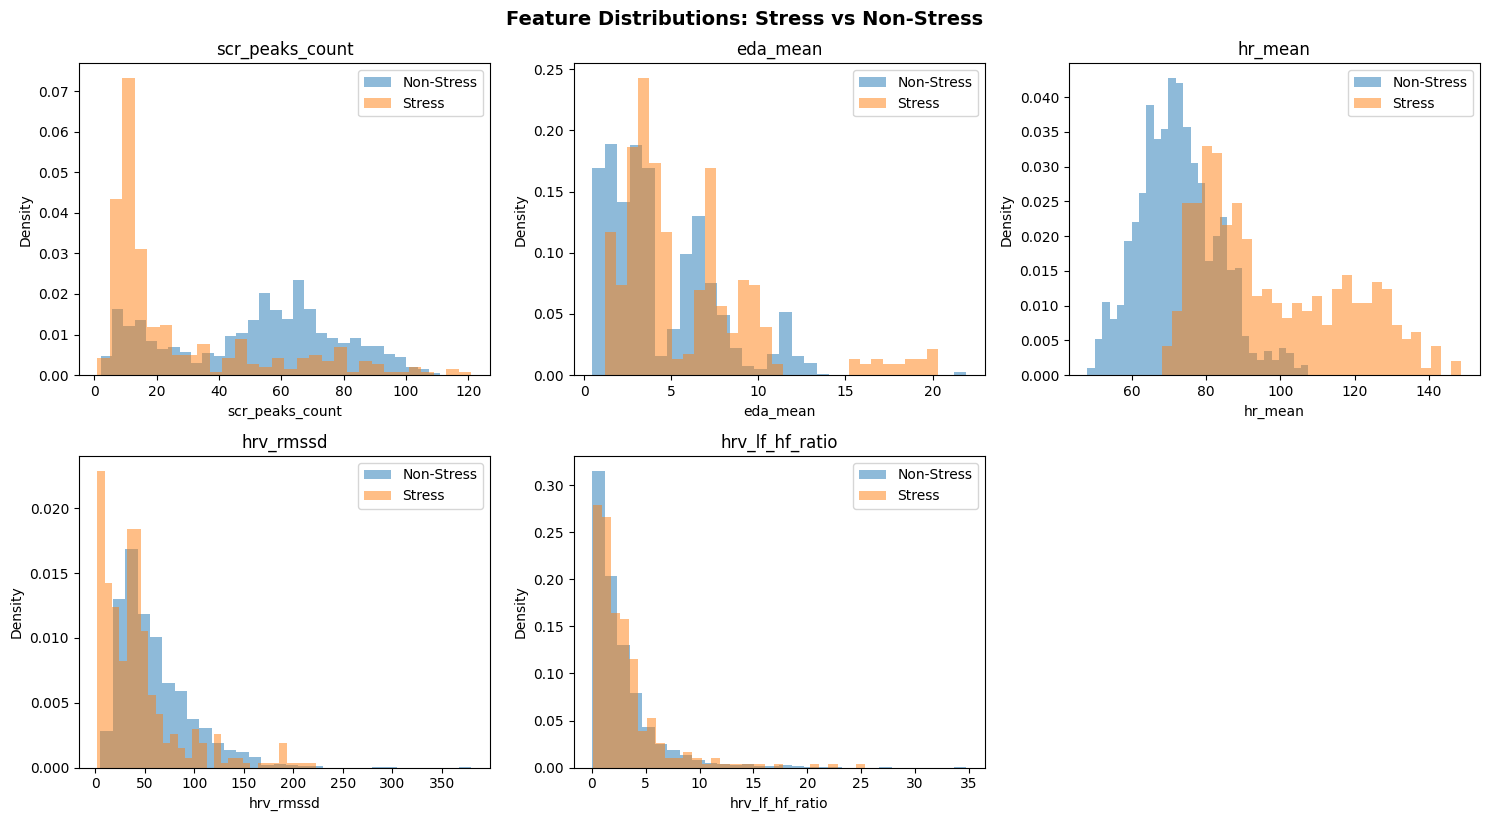


Feature Statistics by Stress Class:
scr_peaks_count     : Stress=   25.83, Non-Stress=   51.81
eda_mean            : Stress=    5.91, Non-Stress=    4.34
hr_mean             : Stress=   97.88, Non-Stress=   72.61
hrv_rmssd           : Stress=   43.50, Non-Stress=   59.81
hrv_lf_hf_ratio     : Stress=    2.89, Non-Stress=    2.79


In [14]:
# Plot distributions of key features by stress vs non-stress
# Binary classification: Stress (label=2) vs Non-Stress (labels=1,3,4)

features_df['stress_binary'] = (features_df['label'] == 2).astype(int)

# Select key features to visualize
key_features = ['scr_peaks_count', 'eda_mean', 'hr_mean', 'hrv_rmssd', 'hrv_lf_hf_ratio']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(key_features):
    ax = axes[i]
    
    # Plot distributions
    stress_data = features_df[features_df['stress_binary'] == 1][feature].dropna()
    non_stress_data = features_df[features_df['stress_binary'] == 0][feature].dropna()
    
    ax.hist(non_stress_data, bins=30, alpha=0.5, label='Non-Stress', density=True)
    ax.hist(stress_data, bins=30, alpha=0.5, label='Stress', density=True)
    
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.legend()
    ax.set_title(f'{feature}')

# Remove extra subplot
fig.delaxes(axes[5])

plt.tight_layout()
plt.suptitle('Feature Distributions: Stress vs Non-Stress', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Print statistics
print('\nFeature Statistics by Stress Class:')
print('='*60)
for feature in key_features:
    stress_mean = features_df[features_df['stress_binary'] == 1][feature].mean()
    non_stress_mean = features_df[features_df['stress_binary'] == 0][feature].mean()
    print(f'{feature:20s}: Stress={stress_mean:8.2f}, Non-Stress={non_stress_mean:8.2f}')

## 4. Training

Binary random forest classifier